In [11]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras
import time


In [12]:
# Nombre de points totals
N = 1000
# Nombre de points d'entrainement 
n_train = 200
# Création de données synthétiques
x = np.linspace(1, 10, N) # peut changer en np.linspace(0, 10, N) pour les fonctions sans le log()

OBJECTIF : Comparer NN et PG sur la prédiction d'une fonction à l'aide de n_train points pour prédire N points ensuite

Fonction à prédire

In [13]:
#y = np.cos(x)
#y = np.cos(x) + x**2 -20 * np.sin(5 * x) 
y = np.log(x) + np.cos(x**2)*4*x

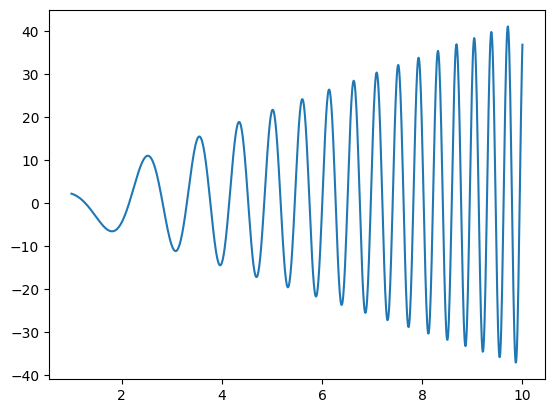

In [14]:
plt.plot(x, y, label='Données originales')

Testons avec differents kernels


Temps d'exécution pour le kernel RationalQuadratic avec 200 points : 0.41387224197387695 secondes
Le nombre de paramètres est de 2 pour le kernel RationalQuadratic
Mean Squared Error : 14.675280652813555


c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


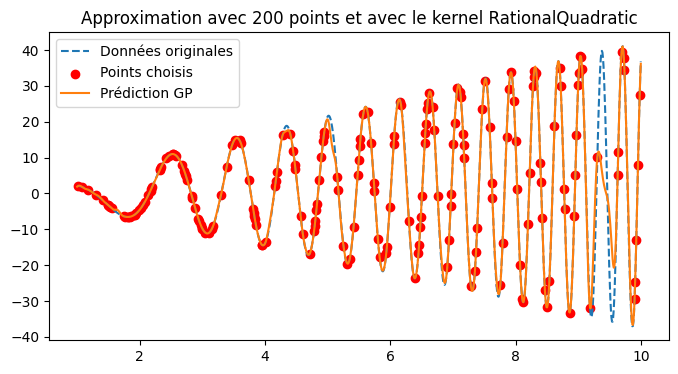

Temps d'exécution pour le kernel ExpSineSquared avec 200 points : 0.09531760215759277 secondes
Le nombre de paramètres est de 2 pour le kernel ExpSineSquared
Mean Squared Error : 14.672801542918236


c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


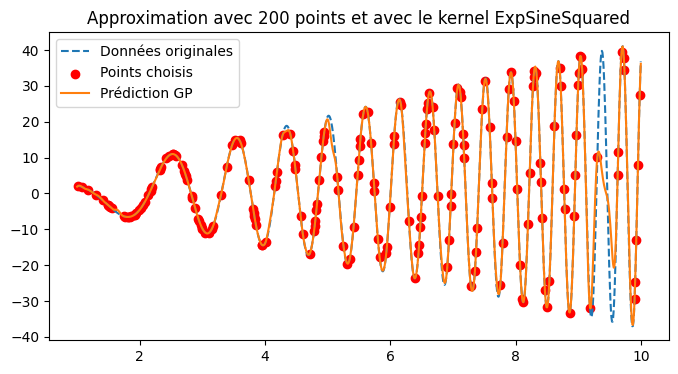

c:\Users\ZEJLI\anaconda3\envs\Transformers\lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Temps d'exécution pour le kernel Matern avec 200 points : 0.009346246719360352 secondes
Le nombre de paramètres est de 1 pour le kernel Matern
Mean Squared Error : 240.8664503488066


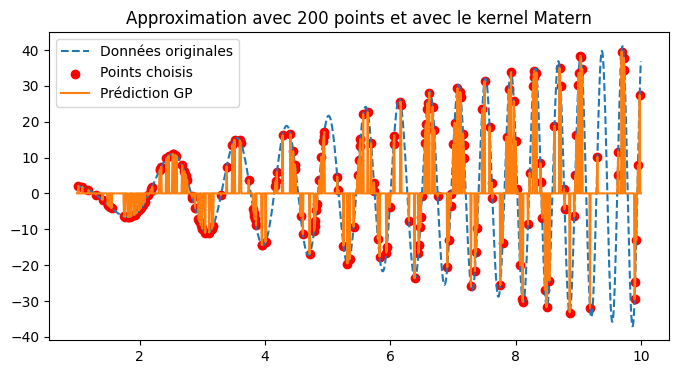

Temps d'exécution pour le kernel RBF avec 200 points : 0.005000591278076172 secondes
Le nombre de paramètres est de 0 pour le kernel RBF
Mean Squared Error : 285.4983770837336


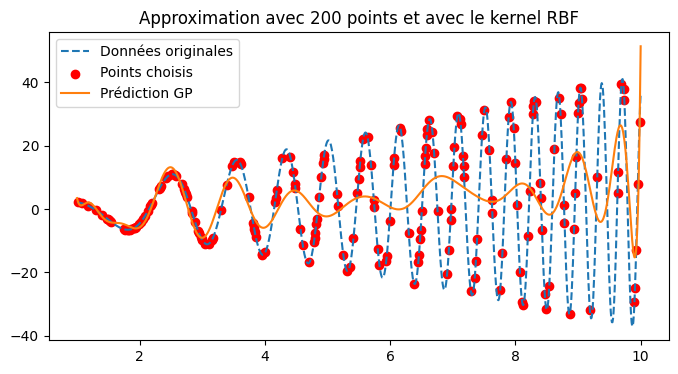

In [15]:
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import Matern
kernel_possible = ["RationalQuadratic", "ExpSineSquared", "Matern","RBF"] # "RBF" (celui par défaut)
indices = np.random.choice(range(N), size=n_train, replace=False)
x_chosen = x[indices]
y_chosen = y[indices]
for kernel_name  in kernel_possible:
     isRBF = False
     if(kernel_name == "RationalQuadratic"):
          kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)
     elif(kernel_name == "ExpSineSquared"):
          kernel = ExpSineSquared(length_scale=1.0, periodicity=3.0) 
     elif(kernel_name == "Matern"):
          kernel = Matern(length_scale=1.0, nu=1.5)
     else:
         isRBF = True
     plt.figure(figsize=(8, 4))

     # Données originales et points choisis
     plt.plot(x, y, label='Données originales', linestyle='dashed')
     plt.scatter(x_chosen, y_chosen, color='red', label='Points choisis')
     # Modèle de processus gaussien
     
     start_time = time.time()
     if (isRBF == False): 
         gp = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kernel)
     else:
         gp = sklearn.gaussian_process.GaussianProcessRegressor() # RBF par défaut
         
     gp.fit(x_chosen.reshape(-1, 1), y_chosen.reshape(-1, 1)) # entrainement avec n_train points
     end_time = time.time()
     print("Temps d'exécution pour le kernel", kernel_name, "avec", n_train, "points :", end_time - start_time, "secondes")
     print("Le nombre de paramètres est de", gp.kernel_.n_dims, "pour le kernel", kernel_name)

     y_pred = gp.predict(x.reshape(-1, 1))
     mse = mean_squared_error(y, y_pred)
     print("Mean Squared Error :", mse)
     # Prédiction
     plt.plot(x, y_pred, label='Prédiction GP')

     plt.legend()
     plt.title(f"Approximation avec {n_train} points et avec le kernel {kernel_name}")
     plt.show()

Comparaison avec un NN

In [16]:
# normalisation

# # norme train
x_chosen_min, x_chosen_max = np.min(x_chosen), np.max(x_chosen)
x_chosen_norm = (x_chosen  - x_chosen_min) / (x_chosen_max - x_chosen_min) 

y_chosen_min, y_chosen_max = np.min(y_chosen), np.max(y_chosen)
y_chosen_norm = (y_chosen - y_chosen_min) / (y_chosen_max - y_chosen_min) 

# norme test

x_min, x_max = np.min(x), np.max(x)
x_norm = (x - x_min) / (x_max - x_min) 

y_min, y_max = np.min(y), np.max(y)
y_norm = (y - y_min) / (y_max - y_min) 


In [17]:
# architecture du modèle
inputs = tf.keras.Input(shape=(1,))
x1 = tf.keras.layers.Dense(64, activation='relu')(inputs)
x2 = tf.keras.layers.Dense(64, activation='relu')(x1)
outputs = tf.keras.layers.Dense(1)(x2)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
start_time = time.time()
model.compile(optimizer=optimizer, loss='mse')
model.fit(x_chosen_norm, y_chosen_norm, epochs=100, batch_size=32)
end_time = time.time()
print("Temps d'exécution du réseau de neurones avec", n_train, "points :", end_time - start_time, "secondes")


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1674  
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0800 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0624 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0500 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0492 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0496 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0486 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489 
Epoch 16/100
7/7 ━

In [18]:
y_pred_norm = model.predict(x_norm)
y_pred = y_pred_norm * (y_max - y_min) + y_min
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error :", mse)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error : 302.380607730703


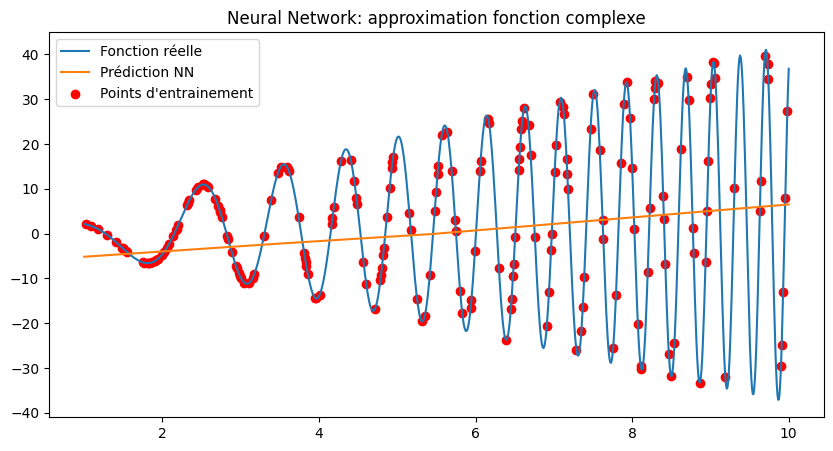

In [24]:
# Visualisation
plt.figure(figsize=(10,5))
plt.plot(x, y, label='Fonction réelle')
plt.plot(x, y_pred, label='Prédiction NN')
plt.scatter(x_chosen, y_chosen, color='red', label='Points d\'entrainement')
plt.legend()
plt.title("Neural Network: approximation fonction complexe")
plt.show()

In [20]:
# nombre de paramètres du réseau de neurones
total_params = model.count_params()
print("Le nombre de paramètres du réseau de neurones est de :", total_params)

Le nombre de paramètres du réseau de neurones est de : 4353
